<a href="https://colab.research.google.com/github/oguzhanatas/ml_TdTk/blob/main/diskboundary_v7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
#https://www.tensorflow.org/tutorials/customization/custom_training_walkthrough
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib

import tensorflow as tf
from tensorflow import keras

from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tqdm.keras import TqdmCallback
tf.__version__

from google.colab import drive
drive.mount('/content/drive',force_remount=True)
path_of_folder = '/content/drive/My Drive/Colab Notebooks/'
data = path_of_folder + 'colab_data/21_RC_SigmaPi005Galpy_new.csv'

path_pop_boundry=path_of_folder +'colab_data/desicion_boundry_rc.txt'

Mounted at /content/drive


alphafe    0
feh        0
snr_a      0
snr_g      0
U          0
V          0
W          0
dtype: int64
42047
    alphafe       feh       snr_a   snr_g          U          V          W  \
0  0.032994  0.060205  343.740997 -9999.0 -15.118205 -27.462988  23.921085   
1  0.054181 -0.299762  205.179001 -9999.0 -44.877055   1.330864  -0.352611   
2  0.036741  0.029631  171.550003 -9999.0  -8.422155 -28.833191 -16.602430   
3  0.044084 -0.314392  265.123993 -9999.0 -50.255022  -2.014292   8.594566   
4  0.010752 -0.003472  714.874023 -9999.0 -32.813834  16.331829  14.781312   

   population  
0           0  
1           0  
2           0  
3           0  
4           0  
alphafe       0
feh           0
snr_a         0
snr_g         0
U             0
V             0
W             0
population    0
dtype: int64
tot:42047, pop1: 16926, pop0: 25121, popNaN: 0
42047


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


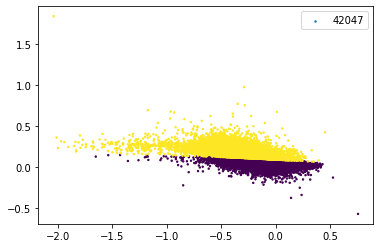

In [30]:
#column_names=['feh_all','alphafe','snr_a','snr_ort_galah','U','V','W','parallax']
rc = pd.read_csv(data, sep=",",low_memory=False)
#for i in rc.columns:
#  print(i)

dataframe=pd.DataFrame({'alphafe':rc['alphafe'],'feh':rc['feh_all'],'snr_a':rc['snr_a'],'snr_g':rc['snr_ort_galah'],'U':rc['U'],'V':rc['V'],'W':rc['W']},index=None).dropna()
print(dataframe.isna().sum())
print(len(dataframe))
#print(dataframe.head())


#dataframe=rc.copy()
pop_boundry=np.loadtxt(path_pop_boundry,delimiter=',')
#pop ayrimi cizgisi
pop_x=np.array(pop_boundry[:,0])
pop_y=np.array(pop_boundry[:,1])
coefs = np.polyfit(pop_x, pop_y, 2)
pop_sel_func = np.poly1d(coefs)
pop_sel_value= pop_sel_func(dataframe['feh'])
thin_mask = (dataframe['alphafe'] <= pop_sel_value)
thick_mask = (dataframe['alphafe'] > pop_sel_value)


thin_data=dataframe[thin_mask]
thin_data['population']=[0]*len(thin_data)
thick_data=dataframe[thick_mask]
thick_data['population']=[1]*len(thick_data)

#dataset = thin_data2.append(thick_data2,ignore_index=True, sort=False)
dataset=pd.concat([thin_data,thick_data],ignore_index=True, axis=0,)
print(dataset.head())
print(dataset.isna().sum())


plt.scatter(dataset['feh'],dataset['alphafe'],c=dataset['population'],s=2,label='{}'.format(len(dataset['population'][(dataset['population']==0)|(dataset['population']==1)])))
plt.legend()
print('tot:{}, pop1: {}, pop0: {}, popNaN: {}'.format(len(dataset['population']),len(dataset['population'][dataset['population']==1]),len(dataset['population'][dataset['population']==0]),dataset['population'].isnull().sum()))
print(len(dataset['population'][dataset['population']==1])+len(dataset['population'][dataset['population']==0])+dataset['population'].isnull().sum())

In [31]:
column_names=['alphafe','feh','U','V','W','population']
feature_names=column_names[:-1]
label_name=column_names[-1]

print("Features: {}".format(feature_names))
print("Label: {}".format(label_name))

Features: ['alphafe', 'feh', 'U', 'V', 'W']
Label: population


In [32]:
population_names = ['thin', 'thick']

In [33]:
dataset[column_names].to_csv(path_of_folder +'colab_data/train_dataset_rc.csv',sep=',',index=None)
data_new=path_of_folder +'colab_data/train_dataset_rc.csv'

df=pd.read_csv(data_new,sep=',')
print(df.columns)


batch_size = len(df)

train_dataset = tf.data.experimental.make_csv_dataset(
    data_new,
    batch_size,
    column_names=column_names,
    label_name=label_name,
    num_epochs=100)


Index(['alphafe', 'feh', 'U', 'V', 'W', 'population'], dtype='object')


In [34]:
features, labels = next(iter(train_dataset))

print(features)

OrderedDict([('alphafe', <tf.Tensor: shape=(42047,), dtype=float32, numpy=
array([0.071529  , 0.03325501, 0.016425  , ..., 0.30351174, 0.12323421,
       0.02623183], dtype=float32)>), ('feh', <tf.Tensor: shape=(42047,), dtype=float32, numpy=
array([-0.29545155, -0.24443156,  0.02651245, ..., -0.57626915,
       -0.03319359, -0.06867743], dtype=float32)>), ('U', <tf.Tensor: shape=(42047,), dtype=float32, numpy=
array([  9.722279, -31.921854,  28.658485, ...,  76.09792 , -43.831963,
        50.394394], dtype=float32)>), ('V', <tf.Tensor: shape=(42047,), dtype=float32, numpy=
array([-20.924013 , -22.945183 ,   3.0539572, ..., -68.25343  ,
        -9.380915 ,   9.83293  ], dtype=float32)>), ('W', <tf.Tensor: shape=(42047,), dtype=float32, numpy=
array([  0.49787933, -16.685032  ,   4.8191733 , ..., -55.72977   ,
        -7.4447923 ,   7.046908  ], dtype=float32)>)])


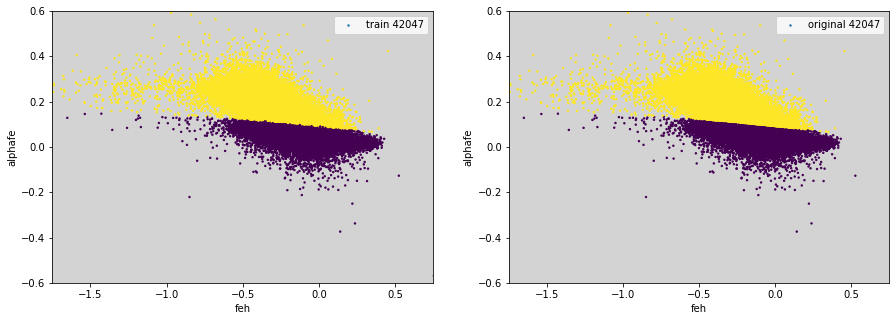

In [35]:
fig=plt.figure()
fig.set_figheight(5)
fig.set_figwidth(15)
ax, ax2 = fig.add_subplot(1, 2, 1), fig.add_subplot(1, 2, 2)# nrows, ncols, index
ax.set_facecolor('lightgray')
ax2.set_facecolor('lightgray')
ax.scatter(features['feh'],
            features['alphafe'],
            c=labels, s=2, label='train {}'.format(len(features['feh'])))

ax2.scatter(dataset['feh'],
            dataset['alphafe'],
            c=dataset['population'], s=2, label='original {}'.format(len(dataset['feh'])))
for i in [ax,ax2]:
  i.set_xlabel('feh')
  i.set_ylabel('alphafe')
  i.set_xlim(-1.75,0.75)
  i.set_ylim(-0.6,0.6)
  i.legend(loc='upper right')

plt.show()

In [36]:
def pack_features_vector(features, labels):
  """Pack the features into a single array."""
  features = tf.stack(list(features.values()), axis=1)
  return features, labels

In [37]:
train_dataset = train_dataset.map(pack_features_vector)

In [38]:
features, labels = next(iter(train_dataset))

print(features[:5])

tf.Tensor(
[[ 2.23809965e-02 -7.92585462e-02  2.17109623e+01  1.21802797e+01
   2.55091133e+01]
 [ 2.45999955e-02  4.20064516e-02  4.00242882e+01 -2.13639164e+01
   1.12721405e+01]
 [ 5.46630174e-02 -2.82881558e-01  5.36181870e+01 -1.63459320e+01
  -1.24915228e+01]
 [ 6.70419931e-02 -4.22391534e-01  4.78721237e+01  4.16195250e+00
   1.80378704e+01]
 [ 2.13779956e-02  1.29358456e-01 -1.31956081e+01 -3.59776306e+01
   1.18527851e+01]], shape=(5, 5), dtype=float32)


In [39]:
model = tf.keras.Sequential([
  tf.keras.layers.Dense(10, activation=tf.nn.relu, input_shape=(5,)),  # input shape required
  tf.keras.layers.Dense(10, activation=tf.nn.relu),
  tf.keras.layers.Dense(3)
])

In [40]:
predictions = model(features)
predictions[:5]

<tf.Tensor: shape=(5, 3), dtype=float32, numpy=
array([[  5.310829 ,   5.510726 , -12.582248 ],
       [  3.8568761,   5.589492 ,  -8.375471 ],
       [  4.323554 ,   5.1296344,  -6.1389914],
       [  7.4705667,   5.6894703,  -8.2228775],
       [  8.144698 ,  14.159016 , -18.669443 ]], dtype=float32)>

In [41]:
tf.nn.softmax(predictions[:5])

<tf.Tensor: shape=(5, 3), dtype=float32, numpy=
array([[4.5019153e-01, 5.4980844e-01, 7.6301445e-09],
       [1.5025321e-01, 8.4974611e-01, 7.3178381e-07],
       [3.0872363e-01, 6.9126749e-01, 8.8256029e-06],
       [8.5583210e-01, 1.4416778e-01, 1.3086164e-07],
       [2.4375592e-03, 9.9756241e-01, 5.5172253e-15]], dtype=float32)>

In [42]:
print("Prediction: {}".format(tf.argmax(predictions, axis=1)))
print("    Labels: {}".format(labels))

Prediction: [1 1 1 ... 1 1 0]
    Labels: [0 0 0 ... 1 1 1]


In [43]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [44]:
def loss(model, x, y, training):
  # training=training is needed only if there are layers with different
  # behavior during training versus inference (e.g. Dropout).
  y_ = model(x, training=training)

  return loss_object(y_true=y, y_pred=y_)


l = loss(model, features, labels, training=False)
print("Loss test: {}".format(l))

Loss test: 4.87533712387085


In [45]:
def grad(model, inputs, targets):
  with tf.GradientTape() as tape:
    loss_value = loss(model, inputs, targets, training=True)
  return loss_value, tape.gradient(loss_value, model.trainable_variables)

In [46]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)

In [47]:
loss_value, grads = grad(model, features, labels)

print("Step: {}, Initial Loss: {}".format(optimizer.iterations.numpy(),
                                          loss_value.numpy()))

optimizer.apply_gradients(zip(grads, model.trainable_variables))

print("Step: {},         Loss: {}".format(optimizer.iterations.numpy(),
                                          loss(model, features, labels, training=True).numpy()))

Step: 0, Initial Loss: 4.87533712387085
Step: 1,         Loss: 4.5078935623168945


In [ ]:
## Note: Rerunning this cell uses the same model variables

# Keep results for plotting
train_loss_results = []
train_accuracy_results = []

num_epochs = 20

for epoch in range(num_epochs):
  epoch_loss_avg = tf.keras.metrics.Mean()
  epoch_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()

  # Training loop - using batches of 32
  for x, y in train_dataset:
    # Optimize the model
    loss_value, grads = grad(model, x, y)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    # Track progress
    epoch_loss_avg.update_state(loss_value)  # Add current batch loss
    # Compare predicted label to actual label
    # training=True is needed only if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
    epoch_accuracy.update_state(y, model(x, training=True))

  # End epoch
  train_loss_results.append(epoch_loss_avg.result())
  train_accuracy_results.append(epoch_accuracy.result())

  print("Epoch {:03d}: Loss: {:.3f}, Accuracy: {:.3%}".format(epoch,
                                                                epoch_loss_avg.result(),
                                                                epoch_accuracy.result()))

Epoch 000: Loss: 0.619, Accuracy: 68.743%
Epoch 001: Loss: 0.617, Accuracy: 69.104%
Epoch 002: Loss: 0.614, Accuracy: 69.404%
Epoch 003: Loss: 0.611, Accuracy: 69.684%
Epoch 004: Loss: 0.609, Accuracy: 69.929%
Epoch 005: Loss: 0.607, Accuracy: 70.148%
Epoch 006: Loss: 0.605, Accuracy: 70.406%
Epoch 007: Loss: 0.603, Accuracy: 70.676%
Epoch 008: Loss: 0.601, Accuracy: 70.909%
Epoch 009: Loss: 0.599, Accuracy: 71.033%
Epoch 010: Loss: 0.597, Accuracy: 71.234%
Epoch 011: Loss: 0.595, Accuracy: 71.444%
Epoch 012: Loss: 0.594, Accuracy: 71.586%
Epoch 013: Loss: 0.592, Accuracy: 71.695%
Epoch 014: Loss: 0.591, Accuracy: 71.827%
Epoch 015: Loss: 0.589, Accuracy: 71.988%


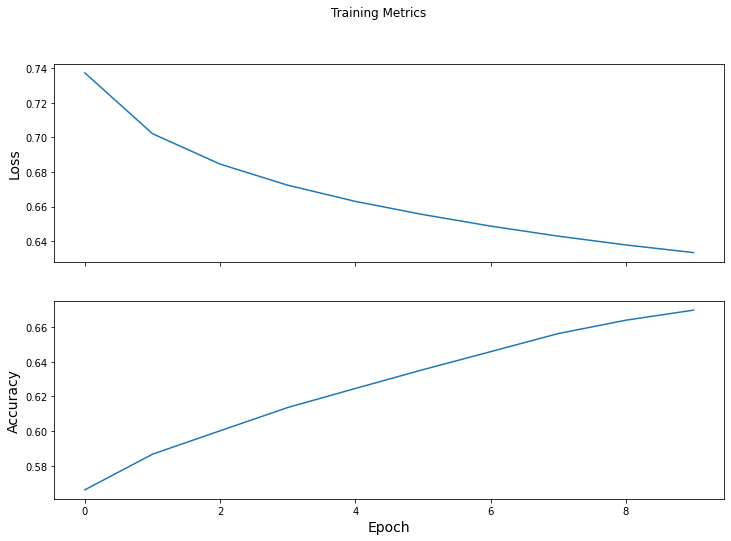

In [50]:
fig, axes = plt.subplots(2, sharex=True, figsize=(12, 8))
fig.suptitle('Training Metrics')

axes[0].set_ylabel("Loss", fontsize=14)
axes[0].plot(train_loss_results)

axes[1].set_ylabel("Accuracy", fontsize=14)
axes[1].set_xlabel("Epoch", fontsize=14)
axes[1].plot(train_accuracy_results)
plt.show()

In [51]:
print("Prediction: {}".format(tf.argmax(predictions, axis=1).numpy()))
print("    Labels: {}".format(labels.numpy()))


#for i,j in zip(tf.argmax(predictions,axis=1),labels):
#  print(i,j)

Prediction: [1 1 1 ... 1 1 0]
    Labels: [0 0 0 ... 1 1 1]


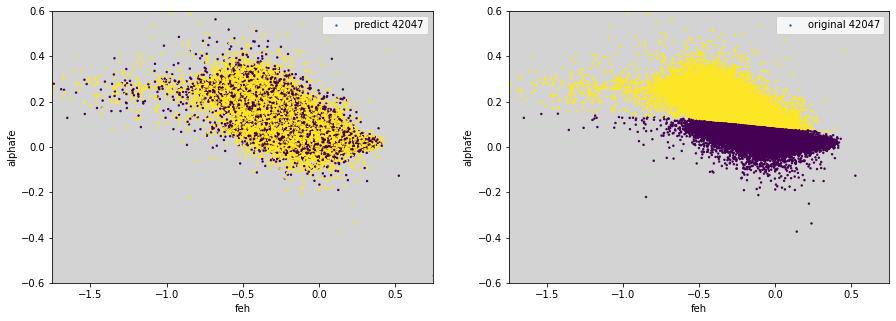

13147 25121
28900 16926
0 0


In [52]:
#for i,j in zip(tf.argmax(predictions, axis=1).numpy(),labels.numpy()):
#  print(i,j)
labels_predict=np.array(tf.argmax(predictions, axis=1).numpy())
fig=plt.figure()
fig.set_figheight(5)
fig.set_figwidth(15)
ax, ax2, = fig.add_subplot(1, 2, 1), fig.add_subplot(1, 2, 2)# nrows, ncols, index
ax.set_facecolor('lightgray')
ax2.set_facecolor('lightgray')
ax.scatter(dataset['feh'],
            dataset['alphafe'],
            c=labels_predict, s=2, label='predict {}'.format(len(labels_predict)))

ax2.scatter(dataset['feh'],
            dataset['alphafe'],
            c=dataset['population'], s=2, label='original {}'.format(len(dataset['population'])))
for i in [ax,ax2]:
  i.set_xlabel('feh')
  i.set_ylabel('alphafe')
  i.set_xlim(-1.75,0.75)
  i.set_ylim(-0.6,0.6)
  i.legend(loc='upper right')

plt.show()

print(len(labels_predict[labels_predict==0.0]),len(dataset['population'][dataset['population']==0]))
print(len(labels_predict[labels_predict==1.0]),len(dataset['population'][dataset['population']==1]))
print(len(labels_predict[labels_predict==2.0]),dataset['population'].isnull().sum())
mask=(dataset['population']==1)&(dataset['population']==0)
#for i in dataset['population'][~mask]:
#  print(i)

array([0., 0., 0., ..., 0., 1., 0.], dtype=float32)